In [11]:
import numpy as np
import numba as nb
import numba.cuda as cuda
from numba.cuda.random import xoroshiro128p_normal_float32, create_xoroshiro128p_states

from config import *

In [12]:
from importlib import reload

In [13]:
import schema
reload(schema)
strong_euler_path = schema.strong_euler_path

from user import a, b, exact
from config import x_0, THREADS, BLOCKS, K

In [14]:
@cuda.jit
def caller(an_array, init_point, state):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw
    if pos < an_array.size:  # Check array boundaries
        an_array[pos] = strong_euler_path(init_point, 0, 3, 100, a, b, exact, state)

In [15]:
result = np.zeros(shape=(K,)).astype('float32')
d_result = cuda.to_device(result)
d_ary = cuda.to_device(x_0)
rng_states = create_xoroshiro128p_states(THREADS * BLOCKS, seed=2)
caller[BLOCKS, THREADS](d_result, d_ary, rng_states)
d_result.copy_to_host(result)

C:\Users\marcin\PycharmProjects\cuSDE\venv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (8) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [16]:
res = d_ary.copy_to_host()
res

array([[0],
       [0],
       [0]])

In [24]:
from numba.cuda.random import xoroshiro128p_normal_float32

@cuda.jit(device=True)
def gen(state):
    thread_id = cuda.grid(1)
    return xoroshiro128p_normal_float32(state, thread_id)

@cuda.jit
def tester(an_array, state):
    # Thread id in a 1D block
    tx = cuda.threadIdx.x
    # Block id in a 1D grid
    ty = cuda.blockIdx.x
    # Block width, i.e. number of threads per block
    bw = cuda.blockDim.x
    # Compute flattened index inside the array
    pos = tx + ty * bw

    if pos < an_array.size:  # Check array boundaries
        an_array[pos] = gen(state)

In [26]:
result = np.zeros(shape=(K,)).astype('float32')
d_result = cuda.to_device(result)
d_ary = cuda.to_device(x_0)
rng_states = create_xoroshiro128p_states(THREADS * BLOCKS, seed=2)
tester[BLOCKS, THREADS](d_result, rng_states)
d_result.copy_to_host(result)

C:\Users\marcin\PycharmProjects\cuSDE\venv\lib\site-packages\numba\cuda\compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (8) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([-1.5159574 ,  0.08290885, -0.577169  ,  0.99387056,  1.8487535 ,
       -0.5252328 , -0.7574524 , -0.9077959 ,  1.3674812 , -0.10852649,
       -0.6516163 , -0.74630064, -0.11243716,  1.3418349 , -0.6088505 ,
        0.10152206], dtype=float32)

In [112]:
K  = 3 # liczba trajektori
N  = 10 # 
d = 2 # wymiar X
mW = 3 # Wymiar W
mN = 1 # Wymiar N 

In [3]:
mi = np.array([0.5, 0.7])
sigma = np.array([[0.5,   0.7,  0.2],
                  [-0.5, -0.7, -0.2]])
cc = np.array([[1.25],
               [0.75]])

In [130]:
x = np.ones(6).reshape((2, 3))
x

array([[1., 1., 1.],
       [1., 1., 1.]])

In [131]:
b(0, x)

array([[[ 0.5,  0.7,  0.2],
        [-0.5, -0.7, -0.2]],

       [[ 0.5,  0.7,  0.2],
        [-0.5, -0.7, -0.2]]])

In [132]:
c(0, x)

ValueError: cannot reshape array of size 4 into shape (2,3)

In [117]:
# dryft
def a(t, x):
    return mi * x

In [118]:
# dyfuzja
def my_b(x):
    return  np.array([sigma[i] * x[i]
                      for i in range(d)])
def b(t, x):
    return  np.apply_along_axis(my_b, 1, x )

In [126]:
# to tylko dla rownania B-S-M
def b_(t, x, j):
    d_ = sigma.shape[0]
    mw_ = sigma.shape[1]
    def my_b_(x):
        return  np.diagflat(np.array([sigma[i] for i in range(d_)])[:,j])
    return  np.apply_along_axis(my_b_, 1, x )

In [127]:
def my_c(x):
    return  np.array([cc[i]*x[i] for i in range(d)])
def c(t, x):
    return  np.apply_along_axis(my_c, 1, x ).reshape(x.shape[0],x.shape[1])

In [ ]:
def my_c_(t,x,j):
  d_ = cc.shape[0]
  mn_ = cc.shape[1]
  def my_c_(x):
    return  np.diagflat(np.array([cc[i] for i in range(d_)])[:,j])
  return  np.apply_along_axis(my_c_, 1, x )

In [ ]:
def L_1b(t,x):
  return b(t,x+c(t,x)) - b(t,x)

In [ ]:
def L_1c(t,x):
  return c(t,x+c(t,x)) - c(t,x)

In [ ]:
def my_vect_mul_vect(x,y):
  return  np.array([x[i]*y[i] for i in range(x.shape[0])])

def my_vect_mul(x,y):
  return  np.array([np.matmul(x[i],y[i]) for i in range(x.shape[0])])

def my_vect_norm(x):
  return  np.array([np.linalg.norm(x[i]) for i in range(x.shape[0])])

#np.apply_along_axis(my_vect_mul, -1, B )



In [ ]:
def exact(x_0, t, W, N):
  x = np.copy(x_0)

  x = x * np.exp((a(t,x*0+1) - (np.power(b(t,x*0+1),2)).sum(axis=2)/2) *t + my_vect_mul(b(t,x*0+1),W))*np.power((1+c(t,x*0+1)),N)
  return x


In [ ]:
1+cc

array([[2.25],
       [1.75]])

In [ ]:
x0 = [1,2]

In [ ]:
x0 = np.array([x0 for i in range(K)])

In [ ]:
x0

array([[1, 2],
       [1, 2],
       [1, 2]])

In [ ]:
dt = 0.00001
dW = np.array([[0.4,0.6,-0.3],[0.4,0.6,-0.3],[0.4,0.6,-0.3]])
dN = np.array([[2],[1],[3]])
dW = np.sqrt(dt) * np.random.randn(K,mW)
dN = np.random.poisson(dt, (K,mN))

In [ ]:
euler_value = x0 + a(0,x0)*dt + my_vect_mul(b(0,x0),dW) + my_vect_mul_vect(c(0,x0),dN)

In [ ]:
exac_value = exact(x0,dt,dW,dN)

In [ ]:
exac_value = exact(x0,dt,dW,dN)
np.power(euler_value - exac_value,2).sum(axis=1).mean()

5.3071280813919614e-11

In [ ]:
j1=1
j2=0
my_vect_mul(b_(0,x0,j1), b(0,x0)[:,:,j2])

array([[0.35, 0.7 ],
       [0.35, 0.7 ],
       [0.35, 0.7 ]])

In [ ]:
my_vect_mul(b_(1,x0,1), b(1,x0)[:,:,2])

array([[0.14, 0.28],
       [0.14, 0.28],
       [0.14, 0.28]])

In [ ]:
def euler(x,A,B,C,dt,dW,dN):
    return x + A * dt + my_vect_mul(B,dW) + my_vect_mul_vect(C,dN)

In [ ]:
def milstein(t,x,A,B,C,dt,dW,dN):
    temp = x + A * dt + my_vect_mul(B,dW) + my_vect_mul_vect(C,dN)
    for j1 in range(mW):
        for j2 in range(mW):
            if j1==j2:
                I = dW[:,j1]**2 - dt
            else:
                I = dW[:,j1]*dW[:,j2]
            temp += my_vect_mul_vect(my_vect_mul(b_(t,x,j1), B[:,:,j2]) ,  I / 2 )
    #print(dW*dN)
    temp += my_vect_mul(L_1b(t,x),dW * dN)
    #print(dN*(dN-1))
    temp += my_vect_mul_vect(L_1c(t,x),dN*(dN-1))
    return temp

In [ ]:
import tqdm as tqdm

In [ ]:
def gen_traj_eq(x0,T,n,K):
      x = np.array([x0 for i in range(K)])
      x2 = np.array([x0 for i in range(K)])
      x_exact = np.array([x0 for i in range(K)])
      x0 =np.array([x0 for i in range(K)])
      traj = np.array([x])
      traj2 = np.array([x2])
      time = np.array([0])
      W = np.zeros((K,mW))
      N = np.zeros((K,mN))
      step = T/n
      t = 0
      t += step
      with tqdm.tqdm(total=T) as pbar:
            while t <= T:

                  dW = np.sqrt(step) * np.random.randn(K,mW)
                  dN = np.random.poisson(step, (K,mN))
                  W+=dW
                  N+=dN
                  x = euler(x,a(t,x),b(t,x),c(t,x),step,dW,dN)
                  traj = np.append(traj,[x])
                  x2 = milstein(t,x2,a(t,x2),b(t,x2),c(t,x2),step,dW,dN)
                  traj2 = np.append(traj2,[x2])
                  time = np.append(time,[t])

                  x_exact = np.append(x_exact,exact(x0,t,W,N))
                  pbar.update(step)
                  t += step
      return time, traj, traj2, x_exact


In [ ]:
K = 20000
N=100

 97%|█████████▋| 0.970858266775844/1 [05:38<00:10, 348.20s/it]


In [ ]:
t,E,M,EV = gen_traj_eq([1,2], 1, N, K )

 98%|█████████▊| 0.9821428571428582/1 [04:54<00:05, 300.24s/it]


In [ ]:
t

array([0.        , 0.01785714, 0.03571429, 0.05357143, 0.07142857,
       0.08928571, 0.10714286, 0.125     , 0.14285714, 0.16071429,
       0.17857143, 0.19642857, 0.21428571, 0.23214286, 0.25      ,
       0.26785714, 0.28571429, 0.30357143, 0.32142857, 0.33928571,
       0.35714286, 0.375     , 0.39285714, 0.41071429, 0.42857143,
       0.44642857, 0.46428571, 0.48214286, 0.5       , 0.51785714,
       0.53571429, 0.55357143, 0.57142857, 0.58928571, 0.60714286,
       0.625     , 0.64285714, 0.66071429, 0.67857143, 0.69642857,
       0.71428571, 0.73214286, 0.75      , 0.76785714, 0.78571429,
       0.80357143, 0.82142857, 0.83928571, 0.85714286, 0.875     ,
       0.89285714, 0.91071429, 0.92857143, 0.94642857, 0.96428571,
       0.98214286])

In [ ]:
import matplotlib.pyplot as plt

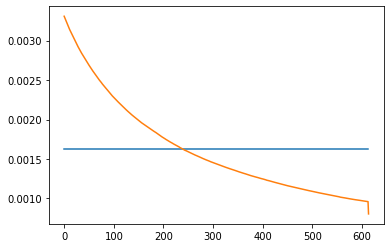

In [ ]:
plt.plot(np.diff(t))

In [ ]:
E = E.reshape(t.shape[0],2,K)
M = M.reshape(t.shape[0],2,K)
EV = EV.reshape(t.shape[0],2,K)

7


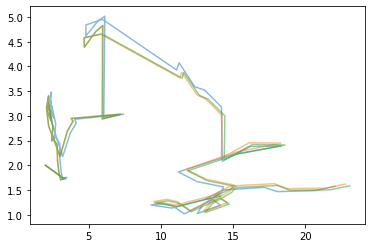

In [ ]:
for i in [7]:
  print(i)
  plt.plot(E[:,0,i],E[:,1,i], alpha=0.5)
  plt.plot(M[:,0,i],M[:,1,i], alpha=0.5)
  plt.plot(EV[:,0,i],EV[:,1,i], alpha=0.5)
plt.show()

In [ ]:
((np.power(M - EV,2).sum(axis=1))/t.shape[0]).sum(axis=0).mean()

0.5719086367477039

In [ ]:
for i in range(1,10):
  N = 2**i
  t,E,M,EV = gen_traj_eq([1,2], 1, N, K )
  E = E.reshape(t.shape[0],2,K)
  M = M.reshape(t.shape[0],2,K)
  EV = EV.reshape(t.shape[0],2,K)
  error_eq = ((np.power(M - EV,2).sum(axis=1))/t.shape[0]).sum(axis=0).mean()
  print(N, t.shape[0], error_eq, )


 34%|███▍      | 0.34121277588194926/1 [00:11<00:21, 32.93s/it]
100%|██████████| 1.0/1 [00:10<00:00, 10.88s/it]


2 3 36.02591564317846 2.7243409068592337 0.07562169783115812


 59%|█████▉    | 0.5919286164542028/1 [00:23<00:15, 39.03s/it]
100%|██████████| 1.0/1 [00:21<00:00, 21.70s/it]


4 5 8.789447177439778 0.5352379701890708 0.06089552157078631


 81%|████████  | 0.8055997447281155/1 [00:53<00:12, 66.64s/it]
 89%|████████▉ | 0.8888888888888891/1 [00:43<00:05, 48.51s/it]


8 9 4.937674085418204 0.2669331161918089 0.05406049722481846


 91%|█████████▏| 0.913798092196262/1 [01:50<00:10, 121.40s/it]
100%|█████████▉| 0.9999999999999996/1 [01:41<00:00, 101.99s/it]


16 20 1.354028379776877 0.6723748903845289 0.49657370585934535


 96%|█████████▌| 0.9564722842971863/1 [03:45<00:10, 235.89s/it]
100%|█████████▉| 0.9999999999999992/1 [03:27<00:00, 207.34s/it]


32 39 1.024657212290608 0.03585274206739868 0.03498998654120663


 98%|█████████▊| 0.9756655442721697/1 [07:27<00:11, 458.38s/it]
 99%|█████████▊| 0.986842105263159/1 [06:44<00:05, 409.56s/it]


64 76 0.4302618364132009 0.016579604313455624 0.038533755286475


 99%|█████████▊| 0.987153916496638/1 [14:52<00:11, 904.15s/it] 
100%|█████████▉| 0.9999999999999979/1 [13:33<00:00, 813.31s/it]


128 153 0.0849978534604841 0.005533166456973854 0.0650977199035532


 99%|█████████▉| 0.9947086695696721/1 [29:55<00:09, 1805.26s/it]
100%|█████████▉| 0.9999999999999963/1 [27:19<00:00, 1639.58s/it]


256 305 0.8074748445322719 0.0009068381295879731 0.0011230543412324592


100%|█████████▉| 0.9968457898498717/1 [1:00:29<00:11, 3641.16s/it]
100%|█████████▉| 0.9983713355048863/1 [55:49<00:05, 3355.17s/it]


512 614 0.050574303667039334 0.007667395408905754 0.15160654429144038
